Andy Friedrich ajf3722

Ashwin Accapadi aja4642

Adarsh Ashok aa85395

Aryan Samal as225468

## Introduction ##
The ML problem we are trying to solve is classification / prediction of NBA player salaries. This is important because the distinction of "star players" who are paid very highly is growing and teams need to discern whether or not they should be paying players as "stars" or to let them go. Obviously players are often analyzed through the eye test and their overall impact on the game, but our model seeks to bring a data-driven approach to contract negotations. Use cases could include an NBA team analyzing a pool of free agent players to find which are "worth" the price they are asking for salary (through regression models) or an analyst classifying players as "highly paid" or not to determine the top 100 players in the league.

Our dataset contains statistics (rebounds, points, FG%, etc) and identifying information (height, weight, position, etc) for over 1600 NBA players, along with a measure of their salary. Our goal in this project is to create models that will accurately predict a player's salary based on their summary statistics.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay

##Data Cleaning##

In [3]:
nba = pd.read_csv('/content/drive/MyDrive/nba_clean.csv')
nba.head()

,Player,FirstName,LastName,Pos,Age,Tm,G,GS,MP_per_game,FG_per_game,...,TOV_totals,PF_totals,PTS_totals,Salary,Height,Weight,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER
0,Precious Achiuwa,Precious,Achiuwa,C,23,TOR,55,12,20.7,3.6,...,59,102,508,2.840160,6-8,225.0,Nigeria,2020,1,20
1,Steven Adams,Steven,Adams,C,29,MEM,42,42,27.0,3.7,...,79,98,361,17.926829,6-11,265.0,New Zealand,2013,1,12
2,Bam Adebayo,Bam,Adebayo,C,25,MIA,75,75,34.6,8.0,...,187,208,1529,30.351780,6-9,255.0,USA,2017,1,14
3,Ochai Agbaji,Ochai,Agbaji,SG,22,UTA,59,22,20.5,2.8,...,41,99,467,3.918360,6-5,215.0,USA,2022,1,14
4,Santi Aldama,Santi,Aldama,PF,22,MEM,77,20,21.8,3.2,...,60,143,696,NaN,6-11,215.0,Spain,2021,1,30


As we load in the dataset, we notice several things. First, there are several columns that we likely do not want to use as predictors; for example, a player's name and the team he plays for are categorical variables that should not have any effect on his salary (based on our prior knowledge of the NBA) and will not be used for our analysis.

In [4]:
# Drop useless columns
nba = nba.drop(columns=['Tm', 'Player', 'FirstName', 'LastName'])

Next, we want to do a cursory analysis of the columns we have access to. We need to see if there are any other columns we want to drop right away, and we also want to see how many missing values we have and determine the best strategy for dealing with them.

In [5]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pos             1684 non-null   object 
 1   Age             1684 non-null   int64  
 2   G               1684 non-null   int64  
 3   GS              1684 non-null   int64  
 4   MP_per_game     1684 non-null   float64
 5   FG_per_game     1684 non-null   float64
 6   FGA_per_game    1684 non-null   float64
 7   FG._per_game    1684 non-null   float64
 8   X3P_per_game    1684 non-null   float64
 9   X3PA_per_game   1684 non-null   float64
 10  X3P._per_game   1684 non-null   float64
 11  X2P_per_game    1684 non-null   float64
 12  X2PA_per_game   1684 non-null   float64
 13  X2P._per_game   1684 non-null   float64
 14  eFG._per_game   1684 non-null   float64
 15  FT_per_game     1684 non-null   float64
 16  FTA_per_game    1684 non-null   float64
 17  FT._per_game    1684 non-null   f

The first thing we notice is that there are about 200 records that have missing data for some of the columns. Unfortunately, these records are in large part missing object data, which makes it extremely difficult to perform any kind of imputation. For this reason, we elect to just get rid of any records that contain null data. Though we will lose data this way, it is the most effective solution because imputation could cause discrepancies in the data. For example, say a player is actually 6'2". If we perform forward/backward fill or similar case imputation and they are assigned a height of 7'2", this would significantly affect the model's training, since we believe that players are valued much higher if they are taller.

In [6]:
# Drop na values
nba = nba.dropna()

##Feature Engineering and More Data Cleaning##

We also see that there are several more object columns. There are a couple more that we believe can be dropped (the season indicator and what country a player is from - neither should have much bearing on how much a player is paid and including the latter through one-hot encoding would significantly increase the dimensionality of our dataset).

However, the others are most likely important. For example, a player's height, expressed here as a string (e.g. "6-11") is extremely important in a basketball league.

We will perform the following transformations:
- drop the country and season objects (cleaning)
- convert the height strings to inches (cleaning)
- create a new feature to represent "undrafted" players (feature engineering - we believe it may be important to consider whether a player was highly touted coming out of college or not)
- convert "undrafted" draft year, draft number, and draft round to representative integers (cleaning)
- one-hot-encode the remaining categorical columns (position) because they are likely important (feature engeineering)

In [7]:
# Function to convert height string to inches
def heights_to_inches(height_str_list):
    height_inches_list = []
    for height_str in height_str_list:
        feet, inches = map(int, height_str.split('-'))
        total_inches = feet * 12 + inches
        height_inches_list.append(total_inches)
    return height_inches_list

In [8]:
nba = nba.drop(columns = ['COUNTRY', 'Season.S.1'])

# Convert strings to integers - Data Cleaning
nba['Height'] = heights_to_inches(nba['Height'])

# Feature Engineering - create "undrafted" feature to place weight on whether or not a player was highly touted coming out of college
nba['Undrafted'] = np.where(nba['DRAFT YEAR'].isin(['Undrafted']) | nba['DRAFT ROUND'].isin(['Undrafted']) | nba['DRAFT NUMBER'].isin(['Undrafted']), 1, 0)
nba['DRAFT ROUND'] = np.where(nba['DRAFT ROUND'].isin(['Undrafted', '']), 3, nba['DRAFT ROUND'])
nba['DRAFT ROUND'] = nba['DRAFT ROUND'].astype(int)
nba['DRAFT YEAR'] = np.where(nba['DRAFT YEAR'] == 'Undrafted', 2022 - nba['Age'] + 20, nba['DRAFT YEAR'])
nba['DRAFT YEAR'] = nba['DRAFT YEAR'].astype(int)
nba['DRAFT NUMBER'] = np.where(nba['DRAFT NUMBER'].isin(['Undrafted', '']), 61, nba['DRAFT NUMBER'])
nba['DRAFT NUMBER'] = nba['DRAFT NUMBER'].astype(int)

# Convert remaining categorical variables to one-hot encoded columns - Feature Engineering
categorical_columns = nba.select_dtypes(include=['object']).columns
nba = pd.get_dummies(nba, columns=categorical_columns, drop_first=True)

nba.head()

,Age,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG._per_game,X3P_per_game,X3PA_per_game,X3P._per_game,...,Pos_PF-SF,Pos_PG,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PG,Pos_SG-PG-SF,Pos_SG-SF
0,23,55,12,20.7,3.6,7.3,0.485,0.5,2.0,0.269,...,False,False,False,False,False,False,False,False,False,False
1,29,42,42,27.0,3.7,6.3,0.597,0.0,0.0,0.000,...,False,False,False,False,False,False,False,False,False,False
2,25,75,75,34.6,8.0,14.9,0.540,0.0,0.2,0.083,...,False,False,False,False,False,False,False,False,False,False
3,22,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,...,False,False,False,False,False,False,True,False,False,False
5,24,59,3,15.0,2.2,5.0,0.444,1.0,2.7,0.384,...,False,False,False,False,False,False,True,False,False,False


# Data Exploration

In this next section we wanted to explore the features of this dataset and see if we could find any correlations to salary. We also wanted to understand the distributions of certain features, to see if there was even enough variability in it to be useful for predictions. Hopefully we can identify patterns in the data that will be useful in the modeling that occurs later.

###Height vs Salary

Mean: 78.35381498987171
Median: 78.0
Mode: 77
Standard Deviation 3.2816649681290477


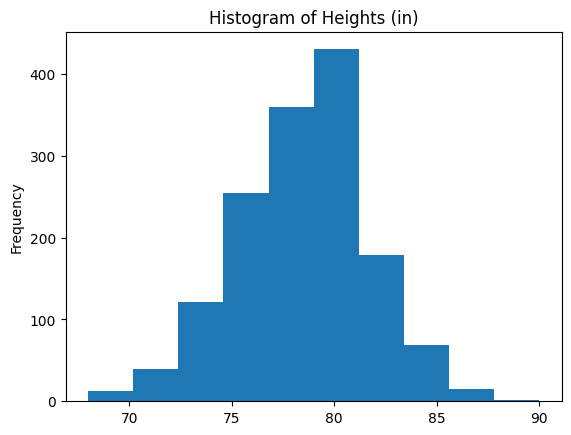

In [9]:
# Get height column and plot its values
heights = nba['Height']
heights.plot(kind='hist', title = 'Histogram of Heights (in)')

print("Mean:", heights.mean())
print("Median:", heights.median())
print("Mode:", heights.mode()[0])
print("Standard Deviation",heights.std())

This histogram of heights clearly shows that there is a relatively normal distribution of heights among basketball players in the NBA. One thing we are curious about is if there is a correlation between height and salary, since it would make sense that people who are insanely tall even for the NBA's standards, get paid more as a result.

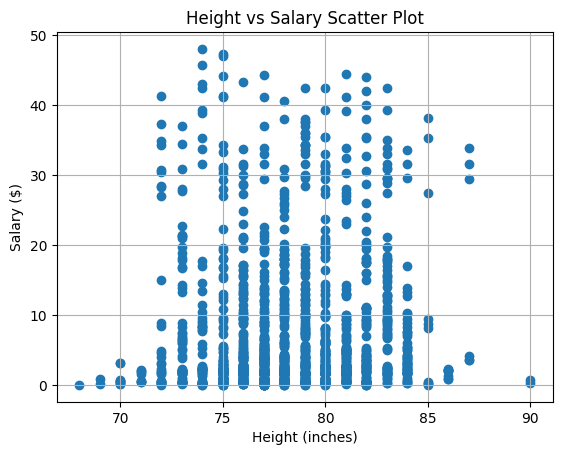

In [10]:
plt.scatter(nba['Height'], nba['Salary'])
plt.title('Height vs Salary Scatter Plot')
plt.xlabel('Height (inches)')
plt.ylabel('Salary ($)')
plt.grid(True)

Based on this plot, we can actually see that there does not seem to be a correlation between height and salary. There is a huge range of salaries for players at the 80 inch mark. Even players above 85 inches do not seem to necesarily make more than players 10 inches shorter than them. It would seem that height may not be a good indicator of salary.

###Age vs Salary

Mean: 25.828494260634706
Median: 25.0
Mode: 24
Standard Deviation 4.201868755926088


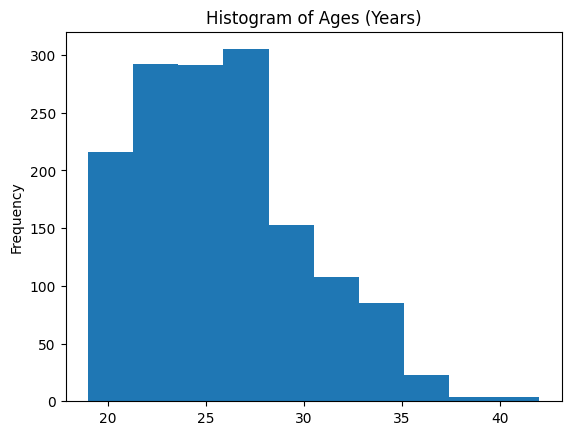

In [11]:
# Get age columns and plot its values
ages = nba['Age']
ages.plot(kind='hist', title = 'Histogram of Ages (Years)')
print("Mean:", ages.mean())
print("Median:", ages.median())
print("Mode:", ages.mode()[0])
print("Standard Deviation",ages.std())

This plot indicates that a majority of NBA players are in the age range of 20-30. It is possible that age could play a factor in salary, since younger players are likely to be on rookie contracts which pay less, and guys who are in their peak performance (late 20s) get paid more.

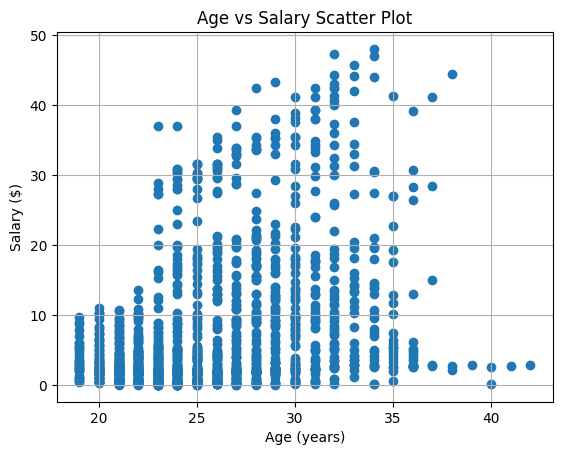

In [12]:
plt.scatter(nba['Age'], nba['Salary'])
plt.title('Age vs Salary Scatter Plot')
plt.xlabel('Age (years)')
plt.ylabel('Salary ($)')
plt.grid(True)

There does seem to be a slightly positive relationship between age and salary. However, it seems that past 35 years of age, the amount of money a players make is significantly lower than that of younger players. This information could be useful in determing salary predictions.

### Points Per Game vs Salary

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.703
Model:                            OLS   Adj. R-squared (uncentered):              0.703
Method:                 Least Squares   F-statistic:                              3503.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):                        0.00
Time:                        01:39:02   Log-Likelihood:                         -4946.8
No. Observations:                1481   AIC:                                      9896.
Df Residuals:                    1480   BIC:                                      9901.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

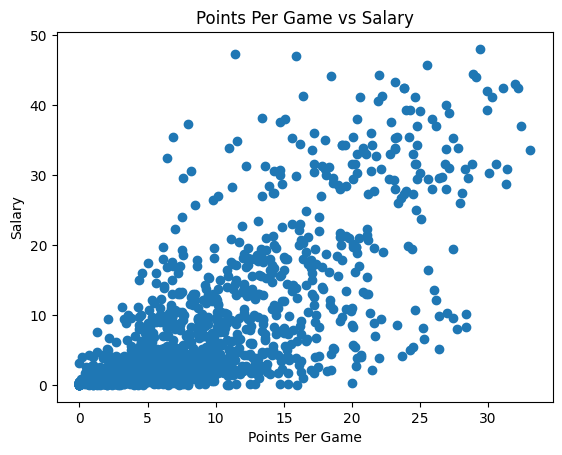

In [13]:
# Scatterplot of points per game vs salary
import statsmodels.api as sm

plt.show()
linear_model = sm.OLS(nba['Salary'], nba['PTS_per_game']).fit()
r_squared = linear_model.rsquared
print(linear_model.summary())

plt.xlabel('Points Per Game')
plt.ylabel('Salary')
plt.title("Points Per Game vs Salary")
plt.scatter(nba['PTS_per_game'],
           nba['Salary'])

Above we observe a moderate, positive, linear relationship between the points per game of an NBA player and an NBA player's salary. This could be useful in helping predict a player's salary.


### Minutes Per Game vs Salary

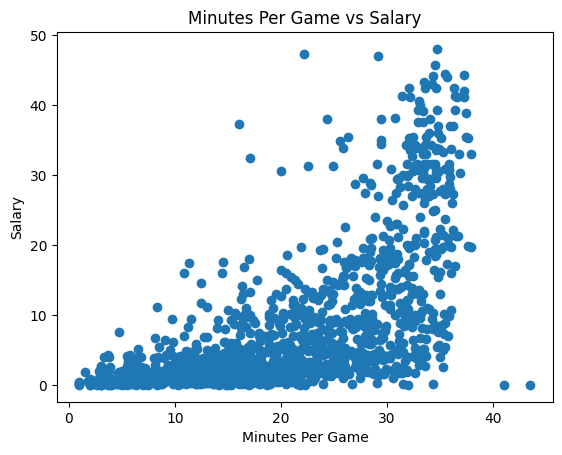

In [14]:
# Scatterplot of minutes per game vs salary

plt.xlabel('Minutes Per Game')
plt.ylabel('Salary')
plt.title("Minutes Per Game vs Salary")
plt.scatter(nba['MP_per_game'],
           nba['Salary'])
plt.show()

Above we observe a strong, positive, exponential relationship between minutes per game and salary. A possible reason for this could be that players who get more minutes get more screen-time, causing fans to generate more hype for these players which motivates teams to give these players higher salaries.


It's also possible that players who receive more minutes are able to score more points which could explain the previous graph as well.


##Correlation Matrix of all Quantitative Features

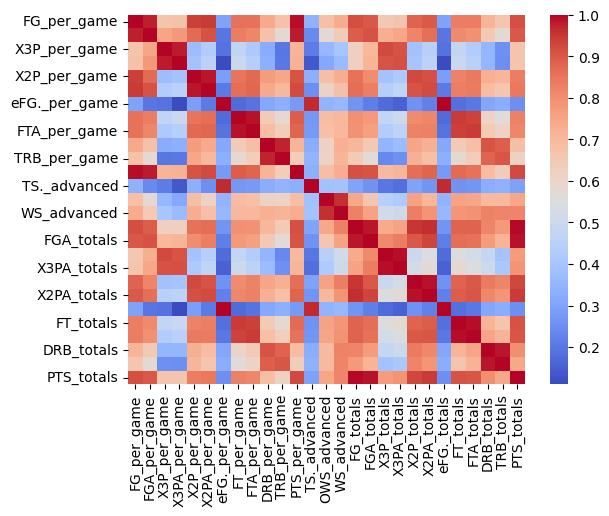

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the features
quant_columns = nba.select_dtypes(include=['float64', 'int64']).columns
correlations = nba[quant_columns].corr()
corr_threshold = .95
mask = (correlations.abs() >= corr_threshold) & (correlations.abs() < 1)
corr_feats = correlations.columns[mask.any()]
nba_correlations = nba[corr_feats]
sns.heatmap(nba_correlations.corr(), annot=False, cmap='coolwarm')
plt.show()

We use this correlation matrix to see how correlated different features are in our dataset. We can see that the majority of features have a correlation of above  0.5. The correlation between features can affect some types of models  and how well they work (see linear regresssion model in the conclusion for more details).

##Additional ML Tasks and More Feature Engineering##

**PCA**

Due to the extremely high dimensionality of our dataset (89 columns) we believe it is necessary to reduce the number of features in order to enable models like k-means. We will scale all of our data to ensure it is weighted equally and then perform PCA to reduce the number of dimensions while retaining 95% of the variance.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop salary - we want to be able to see it afterwards
salaries = nba['Salary']
stats = nba.drop('Salary', axis = 1)

# Scale the data and then use PCA to reduce dimensionality
std_scaler = StandardScaler()
scaled = std_scaler.fit_transform(stats)
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(scaled)
reduced_nba = pd.DataFrame(pca_data)

# Make sure that data looks right
reduced_nba.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.115640,2.804181,1.462814,-0.609744,-1.161360,0.708755,0.325503,1.021873,-0.508834,-0.162623,...,-0.045017,-0.013376,0.327843,-0.074216,-0.372375,0.186281,-0.065393,-0.115724,0.980123,0.062318
1,3.497380,8.248987,4.698965,0.083977,0.678277,1.243628,0.953396,-1.555913,-0.133161,1.536290,...,0.246291,-0.360762,0.598858,-0.612365,-0.481678,0.110628,-0.221869,2.286508,0.463126,-0.269234
2,12.034068,3.333160,5.403608,0.579218,-0.189351,1.223810,-1.713543,0.397411,0.731784,-1.051143,...,0.561567,0.226345,-0.056973,-0.826377,0.622656,0.019847,0.273416,-1.665178,0.303994,-0.430913
3,-1.445051,-1.527207,-1.623961,-1.767695,-1.807528,1.311041,0.136097,1.621878,0.722120,-0.222918,...,-0.272128,0.084799,0.053529,-0.079546,0.032795,-0.088840,-0.076180,0.667215,-0.124953,0.890339
4,-1.802822,-1.168392,-1.690151,-0.372088,-0.266287,1.670900,0.659954,0.962563,0.700404,0.472093,...,-0.245002,0.110336,-0.306737,0.078121,-0.467232,-0.255707,-0.598807,-0.267367,-0.261641,0.540115


**Anomaly Detection**

Outliers are likely a key part of our dataset. For example, we believe that star players like Stephen Curry, Kevin Durant, and LeBron James are likely outliers, which will set them apart in terms of their salary as well. Alternatively, we might find outliers in the other direction, players that have poor statistics and are on league minimum contracts. As such, we will perform Anomaly Detection on our dataset and print out the salaries of outliers we find.

In [17]:
from sklearn.covariance import EllipticEnvelope

from sklearn.utils._testing import ignore_warnings

# Ignore warnings to reduce annoying output UserWarnings
@ignore_warnings()
def anomalies():

  # Consider 10% of data as outliers
  outlier_fraction = 0.1

  # Use elliptic envelope
  elliptic_envelope = EllipticEnvelope(contamination=outlier_fraction, random_state= 0)
  y_pred = elliptic_envelope.fit_predict(nba)

  # Print mean salaries for outliers vs non outliers to analyze any discrepancies
  outlier_salaries = nba[y_pred == -1]['Salary']
  print("Mean salary for data: ", nba['Salary'].mean())
  print("Mean salary for outliers:", outlier_salaries.mean())

anomalies()


Mean salary for data:  7.666106315327482
Mean salary for outliers: 4.852745425675676


We see that our outliers are concentrated in the "low" range of salary more so than the "high" range of salaries. In order to get more granular in our exploration, we want to see if there are distinct groups of players and how that may relate to their salary. To do this we can use unsupervised learning and perform k-means clustering on the data.

However, it is prudent to perform scaling and dimensionality reduction on the data, since k-means relies on distance measures. If we don't scale, features that have higher values (e.g. points per game) would have a much higher significance than features that have lower values (e.g. field goal percentage). On the other hand, if we don't reduce dimensionality, then k-means might break down. We have a lot of columns and an increased number of features means all points are far away from one another.

**Unsupervised Clustering**

Now, using our scaled and reduced data, we can perform k-means clustering. We will try several different values of k to find the one with the lowest silhouette coefficient.

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.utils._testing import ignore_warnings

predictions = []
s_scores = []
for k in range(3,10):
    # Perform k-means
    kmeans = KMeans(n_clusters=k, random_state = 54, n_init='auto')
    pred_labels = kmeans.fit_predict(reduced_nba)

    # Calculate silhouette score
    silhouette = silhouette_score(reduced_nba, pred_labels)
    s_scores.append(silhouette)
    predictions.append(pred_labels)

# Get best silhouette score
best_k = s_scores.index(max(s_scores)) + 2

print(best_k)

# Print mean salaries for clusters to determine if statistics separate players into groups
for i in range(best_k):
  cluster_salaries = salaries[predictions[best_k] == i]
  print("Mean salary for cluster ", i, ": ", cluster_salaries.mean())
  print("Std for cluster ", i, ": ", cluster_salaries.std())



4
Mean salary for cluster  0 :  0.6409247000000001
Std for cluster  0 :  0.981551837532295
Mean salary for cluster  1 :  6.68498765012407
Std for cluster  1 :  6.806556368183133
Mean salary for cluster  2 :  28.21947498809524
Std for cluster  2 :  11.778597487102891
Mean salary for cluster  3 :  2.2595253031161473
Std for cluster  3 :  3.441008566744125


We get 4 as the best number of clusters here, which would indicate 4 distinct groups. Based on the vast discrepancies in salary between the 4 clusters, we postulate that the cluster with the largest salary represents "star players" - the very best players who make large sums of money, while the lowest cluster represents players on the league minimum contract who sit on the bench during games. With the results of this clustering in mind, we have a pretty good idea that the statistics in our dataset are a predictor of a player's salary, so we can proceed with model creation confidently.

##Modeling##

#### Classification Models####

Our first models will be classification models. We want to see if we can predict at a very simple level whether a player is "highly paid" or not. For this purpose, we will set our threshold to be $15.75 million dollars in yearly salary (https://www.espn.com/nba/salaries/_/page/2/seasontype/3 indicates that the top 100 highest-paid players in the league are above this threshold, and we want to see if we can identify these players based on their statistics).

In [19]:
# Define "highly paid" players as above the mean of the highest cluster we found minus one standard deviation
salaries_class = (salaries > 15.75).astype(int)

Function to display accuracy and confusion matrix for our models.

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

def display_stats(model, features, labels, folds):
    # Fit the model to the data
    model.fit(features, labels)

    # Calculate cross val scores and print accuracy
    scores = cross_val_score(model, features, labels, cv=folds)
    print("Average accuracy:", scores.mean() * 100, "%")

    # Get the prediction for each record when it is in the test set for cross validation and then print confusion matrix and classification report
    y_pred = cross_val_predict(model, features, labels, cv = folds)
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(salaries_class, y_pred)).plot()
    print(classification_report(salaries_class, y_pred))

**Decision Tree**

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(reduced_nba, salaries_class, test_size = 0.25, random_state = 0)
print("Training set size: ", features_train.shape[0])
print("Test set size: ", features_test.shape[0])

# Train a decision tree and use it to predict the test set, and then print accuracy
dt = DecisionTreeClassifier(criterion="entropy", random_state=0)
dt = dt.fit(features_train, labels_train)
labels_pred = dt.predict(features_test)
print("Accuracy: ", accuracy_score(labels_test, labels_pred))

Training set size:  1110
Test set size:  371
Accuracy:  0.8652291105121294


This worked pretty well, with 86% accuracy. However, we also want to use cross validation to make sure that our process is good and our results are not just subject to random chance.

Average accuracy: 87.57621257621257 %
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1242
           1       0.62      0.61      0.61       239

    accuracy                           0.88      1481
   macro avg       0.77      0.77      0.77      1481
weighted avg       0.88      0.88      0.88      1481



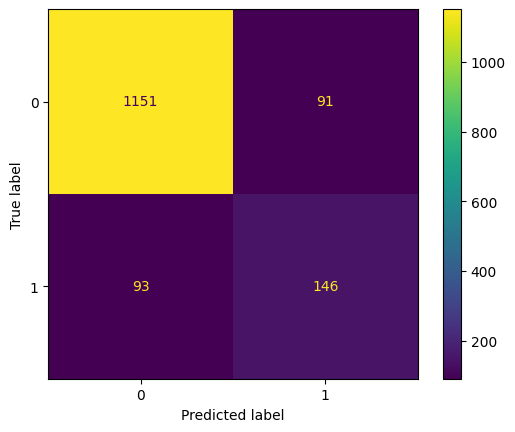

In [22]:
from sklearn.model_selection import GridSearchCV

# Values to try as hyperparameters
param_dict = {
    "max_depth": [5,10,15,20],
    "min_samples_leaf": [5,10,15,20],
    "max_features": [5,10,15]
}

# Set up a grid to try all hyperparameters
grid = GridSearchCV(dt, param_grid = param_dict, cv = 5, scoring = 'accuracy')

# Fit the grid and display its stats
display_stats(grid, reduced_nba, salaries_class, 5)

We were able to improve our process through cross validation. Now, let's try some other models, continuing to use cross validation.

**Naive Bayes**

Average accuracy: 67.55209755209755 %
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1242
           1       0.32      0.87      0.46       239

    accuracy                           0.68      1481
   macro avg       0.64      0.76      0.62      1481
weighted avg       0.86      0.68      0.72      1481



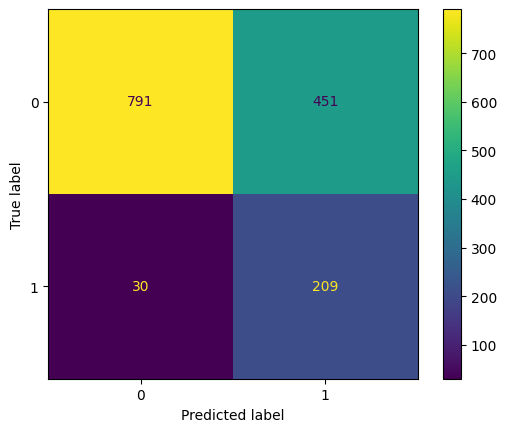

In [23]:
from sklearn.naive_bayes import GaussianNB

# Greate new Naive Bayes model and display its statistics
gnb = GaussianNB()
display_stats(gnb, reduced_nba, salaries_class, 5)

**KNN Classification**

Average accuracy: 91.49399399399398 %
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1242
           1       0.77      0.68      0.72       239

    accuracy                           0.91      1481
   macro avg       0.85      0.82      0.84      1481
weighted avg       0.91      0.91      0.91      1481



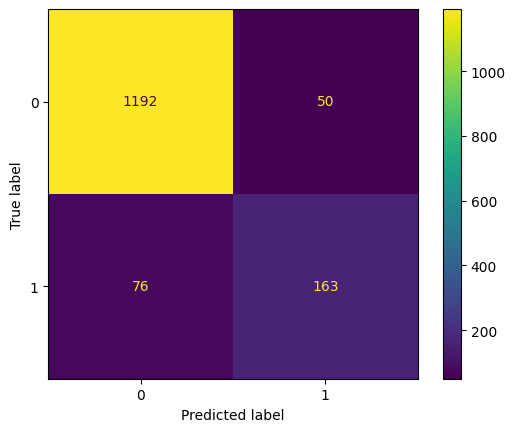

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# Values to try as hyperparams
param_dict = {
    "n_neighbors": [3,5,7,9,11]
}

# Create kmeans classifer and grid to train hyperparams
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = param_dict, cv = 5, scoring = 'accuracy')

# Show stats
display_stats(grid, reduced_nba, salaries_class, 5)

**Neural Network**

Average accuracy: 94.26107926107926 %
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1242
           1       0.84      0.80      0.82       239

    accuracy                           0.94      1481
   macro avg       0.90      0.88      0.89      1481
weighted avg       0.94      0.94      0.94      1481



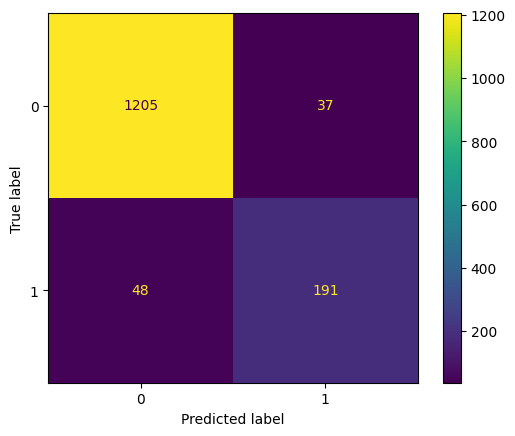

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore convergence warnings to reduce noisy output
@ignore_warnings(category=ConvergenceWarning)
def neuralnet_class():
  mlp = MLPClassifier(random_state=0)

  # Values to try as hyperparams
  param_grid = {
      'hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
      'activation': ['logistic', 'tanh', 'relu']
  }

  # Create grid to use CV to find best hyperparams
  grid = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5)

  # Fit the grid and display its stats
  display_stats(grid, reduced_nba, salaries_class, 5)

neuralnet_class()

**Support Vector Machine (SVM)**

Average accuracy: 92.10141960141961 %
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1242
           1       0.81      0.66      0.73       239

    accuracy                           0.92      1481
   macro avg       0.88      0.82      0.84      1481
weighted avg       0.92      0.92      0.92      1481



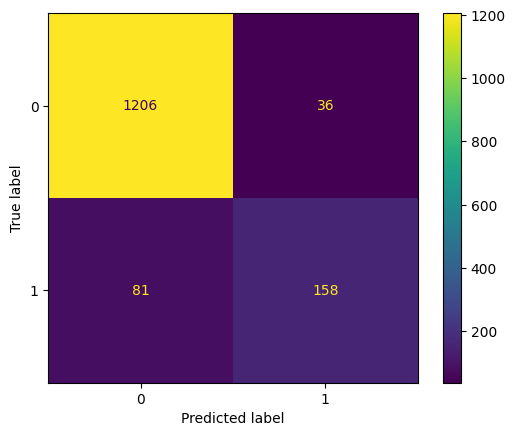

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

svm = SVC()

# Create a pipeline with the SVM classifier
pipeline = Pipeline([
    ('svm', svm)
])

# Param grid for hyperparameters to try
svm_param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly']
}

# Create grid and display its stats
svm_grid_search = GridSearchCV(estimator=pipeline, param_grid=svm_param_grid, cv=5)
display_stats(svm_grid_search, reduced_nba, salaries_class, 5)

## Regression Models ##

The following models would be used for regression tasks, i.e. predicting the salary that an NBA player should earn based on his statistics. Modeling of this kind would have several valuable applications, chiefly in salary negotiation for players and organizations. We will analyze these models through their R^2 and the average residual for the dataset (how far off, on average, the model predicts a player's salary compared to their actual salary).

Function to display stats for regression. Prints the best parameters for CV and the R^2 value for the model. Uses cross validation to predict a salary for every player when they are a member of the test set and compares the predicted values with actual values.

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

def reg_stats(model, features, answers, folds):

    # Fit model
    model.fit(features, answers)

    # Print R2 value and best hyperparams
    print("Best params: ", model.best_params_)
    print("Best R^2: ", model.best_score_)

    # Predict each value when it is in the testing set and find the difference from the actual values
    y_pred = cross_val_predict(model, features, answers, cv = folds)
    differences = y_pred - answers
    print("Mean difference in predictions:", differences.mean())

    # Plot residuals
    plt.figure(figsize=(8, 6))
    plt.scatter(answers, differences, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.show()

**Linear Regression**

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

lin_model = LinearRegression()

# Perform cross-validation with R^2 scoring
avgs = cross_val_score(lin_model, reduced_nba, salaries_class, cv=5, scoring='r2')
average_r2 = np.mean(avgs)

# Get the best estimator
predictions = cross_val_predict(lin_model, reduced_nba, salaries_class, cv = 5)

# Calculate mean difference in salary predictions
differences = predictions - salaries
print("Mean difference in predictions:", differences.mean())

print("Accuracy measured by R-squared (R^2): " + str(average_r2))

Mean difference in predictions: -7.527680520683586
Accuracy measured by R-squared (R^2): -2.7014343025089183


**Regression Neural Network**

Best params:  {'activation': 'relu', 'hidden_layer_sizes': (60,)}
Best R^2:  0.7513966714497241
Mean difference in predictions: -0.04767238903943342


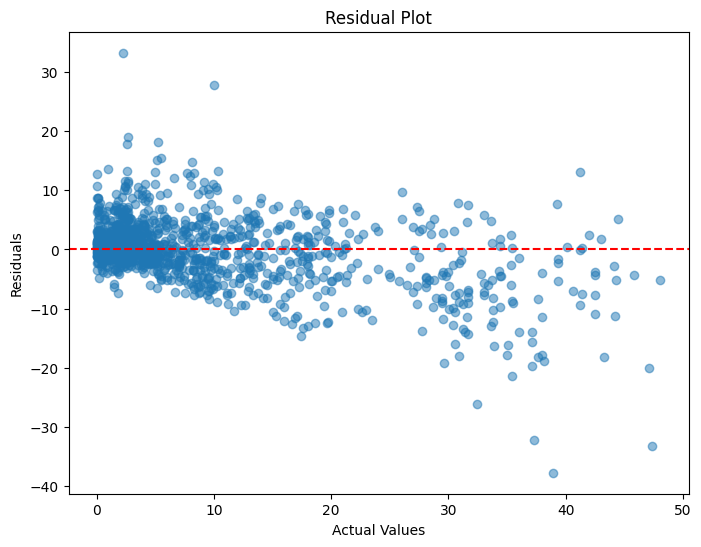

In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def nn_regression():

  mlp = MLPRegressor(random_state=0)

  # Hyperparameters for tuning
  param_grid = {
      'hidden_layer_sizes': [(30,), (40,), (50,), (60,)],
      'activation': ['logistic', 'tanh', 'relu']
  }

  # Create grid, fit, and display its stats
  grid = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5)
  reg_stats(grid, reduced_nba, salaries, 5)

nn_regression()

**Bagging**

Best params:  {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 30}
Best R^2:  0.6977259227246786
Mean difference in predictions: 0.1657133909520595


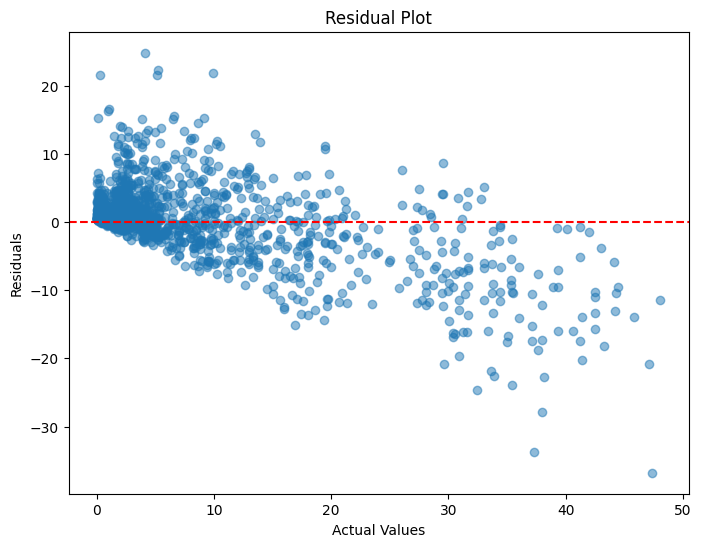

In [30]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Base model that will be used for bagging
base_regressor = DecisionTreeRegressor(random_state=0)

# Hyperparams
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

# Create bagging
bagging_regressor = BaggingRegressor(estimator=base_regressor, random_state=0)

# Create grid, fit, and display stats
grid = GridSearchCV(estimator=bagging_regressor, param_grid=param_grid, cv=5, scoring='r2')
reg_stats(grid, reduced_nba, salaries, 5)


**Boosting**

Best params:  {'learning_rate': 0.1, 'n_estimators': 100}
Best R^2:  0.6474867182710506
Mean difference in predictions: 0.23913637677280009


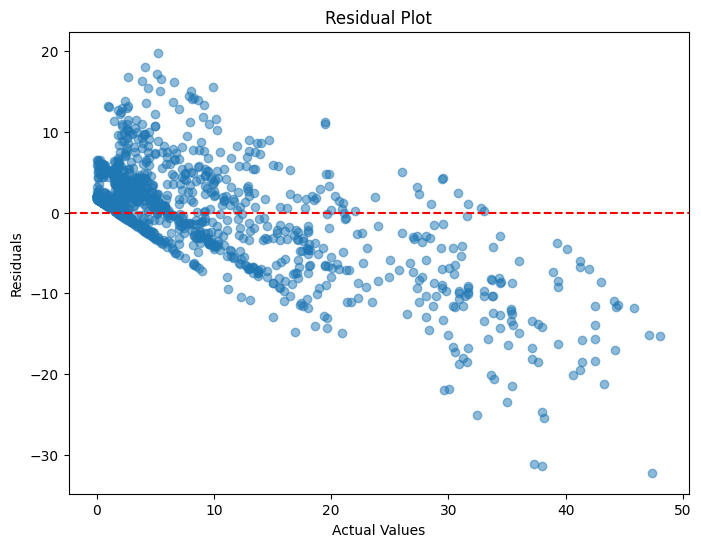

In [31]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

ada_boost_regressor = AdaBoostRegressor(random_state=0)

# Hyperparams
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create grid, fit, display stats
grid = GridSearchCV(estimator=ada_boost_regressor, param_grid=param_grid, cv=5, scoring='r2')
reg_stats(grid, reduced_nba, salaries, 5)

##Outcome/Results##

**Classification Models**

Overall, we were able to acheive favorable results with classification, with most of our models acheiving above 80% accuracy. Our best result predictably came from the Neural Net, which predicted player's salaries being in the top 100 range at an impressive 94.2% clip. We believe that this is due to the neural net's ability to learn complex, diverse decision boundaries like the one in our dataset. We were initially concerned that it would overfit the data, but cross validation indicated that it was still effective on unseen data. SVM was also particularly effective, predicting at about 92.1%. This is likely due to the fact that it is resistant to the curse of dimensionality, which increases its effectiveness on our dataset compared to other models since it has so many features (even after PCA significantly reduced the number of features).

K means and decision trees were also effective models. We believe that our data cleaning was very helpful in making k-means effective, as we removed irrelevant features that could have skewed the results.

We were most disappointed with the outcome of Naive Bayes. We were initially hopeful that it would be a good model for our data because of how it deals with the curse of dimensionality, but in the end it was likely ineffective due to its critical assumption that all features are independent. Many features in our datset are related, such as minutes played and points. As shown in our confusion matrix and statistics, its precision was particularly low for the positive class, meaning that it often predicted that a player would have a high salary when in reality they did not.

In the end, we believe that the outcomes of our models indicate that a player's statistics are very good predictors of his eventual salary. Teams could use our classification models (especially the Neural Net or SVM) to determine whether a player deserves to be paid as a top 100 player in the league, which is a very important distinction since salary cap is limited and building around star players is crucial for teams to be successful.

**Regression Models**

Regression models performed worse compared to the classification models. The regression models predicted the specific salary of an NBA player based on his data. We used R^2 as a metric to evaluate their performance. The regression neural network performed the best, with an R^2 of 0.75. The neural net’s ability to learn complex, diverse decision boundaries gave it an advantage, allowing its average residual to be only -0.047, or about \$47000. This is very impressive, and we believe that this model should definitely be used by teams who are trying to decide how much to pay a player.

The linear regression model performed the worst with an R^2 of -2.7. Considering over 30 features are being taken into account by the linear model, we suspect it broke down due collinearity between features. Collinearity is when the features (predictors) are correlated with each other, causing an increase in variance in predictions and a lack of precision. This overall reduces the accuracy of a linear regression model significantly. Because of the multicollinear nature of the data (seen in the Correlation Matrix above), linear regression is not a suitable model to use. One could argue that we should have simply dropped some of the features that were too highly correlated with other features but this may reduce the performance of other models such as decision trees, and the decision tree model had a very high accuracy. It was over $2.7 million dollars off on its prediction on average, which demonstrates that it is a terrible model not suited for such a mulitcollinear dataset.

The ensemble learners performed reasonably well overall. We believe that they were effective due to the fact that the predictors they ensembled on were relatively good predictors and diverse. The method ‘Bagging’ takes certain subsets of the dataset and trains a base model on each subset. Then each model votes for every data point to predict salary. The bagging regression R^2 was 0.69 and had an average residual of 0.165, meaning that it missed the exact value of the player's salary by \$165,000. The ‘Boosting’ method is similar to bagging except it iterates on the models, weighting incorrectly guessed records more so that the models ‘learn’ from their mistakes. The boosting regression model performed worse with an R^2 of .65 but still had an average residual of 0.2, meaning that it only missed a player's salary by \$200,000 on average.

Regression models had a harder job than classification as they had to predict exactly what the salary of an NBA player was instead of classifying them based on ‘buckets’. However, we were able to gather impressive results from our neural net due to its ability to learn complex patterns. We believe that model would be a formidable tool for negotiation from both a player and team perspective, as each could use it as a starting point for a player's valuation during contract talks.